In [1]:
import pickle
import pprint
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, precision_score, \
    recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


In [2]:
import warnings
warnings.filterwarnings("ignore")

style.use('seaborn-whitegrid')
% matplotlib inline

In [3]:
# # Change format of charts to .svg
%config InlineBackend.figure_format = 'svg'

In [4]:
%xmode Plain

Exception reporting mode: Plain


In [5]:
df = pd.read_csv('data/clean_data_encoded_for_regression.csv')

X = df[['gender', 'senior', 'partner', 'dependents', 'tenure', 'phone_service',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'monthly_charges', 'total_charges',
       'avg_monthly_charges', 'internet_service-fiber_optic',
       'internet_service-no', 'contract-one_year', 'contract-two_year',
       'payment_method-credit_card_auto', 'payment_method-electronic_check',
       'payment_method-mailed_check']]

y = df['churn']

# Stratify our train-test-split so that we have a balanced split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40, stratify=y)

#### Upsample with SMOTE to get a balanced dataset

Currently, only 27% of our dataset is categorized as "Churn" (i.e., will leave the telecom company and no longer be a customer this month). In order to train our model better, we are upsampling with SMOTE so that 50% of our dataset is categorized as "Churn". This makes sense because we are more concerned about recall (making sure our model catches nearly everyone who is likely to churn) than it is about precision.

The rationale? It's much cheaper to keep an existing customer than to acquire a new one.

In [6]:
sm = SMOTE(random_state=42, ratio=1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
print(y_train.value_counts(), np.bincount(y_train_res))

0    3614
1    1308
Name: churn, dtype: int64 [3614 3614]


### Let's do some quick and dirty analyses to determine which models we should tune further

First we'll do ANOTHER train test split on the training set. We want to make sure that we leave our actual test data (X_test and y_test) alone.

In [7]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_train_res, y_train_res, test_size=0.33, random_state=20)

In [8]:
def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    model.fit(xtrain, ytrain)
    return model.score(xtrain, ytrain), model.score(xtest, ytest)


def quick_test_a_few_times(model, X, y, n=10):
    return (pd.DataFrame([quick_test(model, X, y) for j in range(n)],
                         columns=['Train Acc', 'Test Acc'])).mean()

new_model = make_pipeline(StandardScaler(), LinearSVC(max_iter=10000))
# pred = new_model.predict(X_test)
# Do the test 10 times with a LinearSVC and get the average score
print(quick_test_a_few_times(new_model, X_train_2, y_train_2))


Train Acc    0.770493
Test Acc     0.766414
dtype: float64


In [26]:
def get_scores(model):
    mod = model
    mod = mod.fit(X_train_2, y_train_2)
    predictions = mod.predict(X_test_2)
    # quick_test_a_few_times(decisiontree, X_train, y_train)

    print(f'**Model: {mod}**')
    print(f'Train accuracy: {mod.score(X_train_2, y_train_2)}')
    print(f'Test accuracy: {mod.score(X_test_2, y_test_2)}')
    print(f'Precision: {precision_score(y_test_2, predictions)}')
    print(f'Recall: {recall_score(y_test_2, predictions)}')
    print()
    print(classification_report(y_test_2, predictions))
    print()

#### Decision Tree

In [27]:
def evaluate_models(model_types: list):
    for model in model_types:
        m = model_types[model]
        quick_test_a_few_times(X_train_2, y_train_2)
        get_scores(m)


models = [
    {
        'label': 'Logistic Regression',
        'model': LogisticRegression(),
    },
    {
        'label': 'Gradient Boosting',
        'model': GradientBoostingClassifier(),
    },
    {
        'label': 'Random Forest',
        'model': RandomForestClassifier(),
    },
    {
        'label': 'AdaBoost Classifier',
        'model': AdaBoostClassifier(),
    },
    {
        'label': 'Support Vector Classifier',
        'model': SVC(probability=True),
    }
]

# evaluate_models(models)

decision_tree = DecisionTreeClassifier()
quick_test_a_few_times(decision_tree, X_train_2, y_train_2)
get_scores(decision_tree)

Train accuracy: 0.9993804213135068
Test accuracy: 0.7925398155909472
Precision: 0.7878535773710482
Recall: 0.797809604043808


              precision    recall  f1-score   support

           0       0.80      0.79      0.79      1199
           1       0.79      0.80      0.79      1187

   micro avg       0.79      0.79      0.79      2386
   macro avg       0.79      0.79      0.79      2386
weighted avg       0.79      0.79      0.79      2386



#### Random Forests

In [28]:
random_forest = RandomForestClassifier()
quick_test_a_few_times(random_forest, X_train_2, y_train_2)
get_scores(random_forest)

Train accuracy: 0.9884345311854605
Test accuracy: 0.8378038558256496
Precision: 0.8690036900369004
Recall: 0.793597304128054


              precision    recall  f1-score   support

           0       0.81      0.88      0.85      1199
           1       0.87      0.79      0.83      1187

   micro avg       0.84      0.84      0.84      2386
   macro avg       0.84      0.84      0.84      2386
weighted avg       0.84      0.84      0.84      2386



#### Gradient Boosting Classifier

In [29]:
grad_boost = GradientBoostingClassifier()
quick_test_a_few_times(grad_boost, X_train_2, y_train_2)
get_scores(grad_boost)

Train accuracy: 0.8764973151590252
Test accuracy: 0.8562447611064543
Precision: 0.8637931034482759
Recall: 0.8441449031171019


              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1199
           1       0.86      0.84      0.85      1187

   micro avg       0.86      0.86      0.86      2386
   macro avg       0.86      0.86      0.86      2386
weighted avg       0.86      0.86      0.86      2386



#### AdaBoost Classifier

In [30]:
ada_boost = AdaBoostClassifier()
quick_test_a_few_times(ada_boost, X_train_2, y_train_2)
get_scores(ada_boost)

Train accuracy: 0.8597686906237092
Test accuracy: 0.8365465213746857
Precision: 0.8379983036471587
Recall: 0.8323504633529908


              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1199
           1       0.84      0.83      0.84      1187

   micro avg       0.84      0.84      0.84      2386
   macro avg       0.84      0.84      0.84      2386
weighted avg       0.84      0.84      0.84      2386



#### Logistic Regression

In [31]:
logreg = LogisticRegression()
quick_test_a_few_times(logreg, X_train_2, y_train_2)
get_scores(logreg)

Train accuracy: 0.7719950433705081
Test accuracy: 0.7669740150880134
Precision: 0.7482297403619197
Recall: 0.8011794439764112


              precision    recall  f1-score   support

           0       0.79      0.73      0.76      1199
           1       0.75      0.80      0.77      1187

   micro avg       0.77      0.77      0.77      2386
   macro avg       0.77      0.77      0.77      2386
weighted avg       0.77      0.77      0.77      2386



#### Linear SVC (Support Vector Classifier)

In [30]:
linearsvc = LinearSVC()
quick_test_a_few_times(linearsvc, X_train_2, y_train_2)

Train Acc    0.625671
Test Acc     0.624983
dtype: float64

#### SVC with rbf kernel

In [31]:
svc_rbf = SVC(kernel='rbf')
quick_test_a_few_times(svc_rbf, X_train_2, y_train_2)

Train Acc    0.963588
Test Acc     0.759601
dtype: float64

#### SVC with Polynomial kernel

In [ ]:
svc_poly = SVC(kernel='poly')
quick_test_a_few_times(svc_poly, X_train_2, y_train_2)

#### Naive Bayes Classifier

In [ ]:
gaussian_naive_bayes = GaussianNB()
quick_test_a_few_times(gaussian_naive_bayes, X_train_2, y_train_2)

### Adding in pipeline

In [ ]:
model = make_pipeline(StandardScaler(), SVC())
model.fit(X_train_2, y_train_2)
pred = model.predict(X_test_2)

quick_test_a_few_times(model, X_train_2, y_train_2)

In [ ]:
model = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
model.fit(X_train_2, y_train_2)
pred = model.predict(X_test_2)

quick_test_a_few_times(model, X_train_2, y_train_2)

In [ ]:
decisiontree = DecisionTreeClassifier()
decisiontree.fit(X_train_2, y_train_2)
coeffs = decisiontree.feature_importances_ # it's a percentage

list_of_coeffs = list(sorted(zip(coeffs, X.columns)))

In [ ]:
import pprint
pprint.pprint(list_of_coeffs)

In [ ]:
list_of_coeffs = list(sorted(zip(coeffs, X.columns)))
pprint.pprint(list_of_coeffs)

In [ ]:
grad_boost = GradientBoostingClassifier()
grad_boost.fit(X_train_2, y_train_2)
grad_boost.feature_importances_ # values are between 0 and 1, not normalized
grad_boost.train_score_.mean()

In [ ]:
s2 = LinearSVC()
s2.fit(X_train, y_train)
s2.coef_ # the absolute value dictates importance

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg.coef_ # the abosulute value dictates importance

### ROC Curve

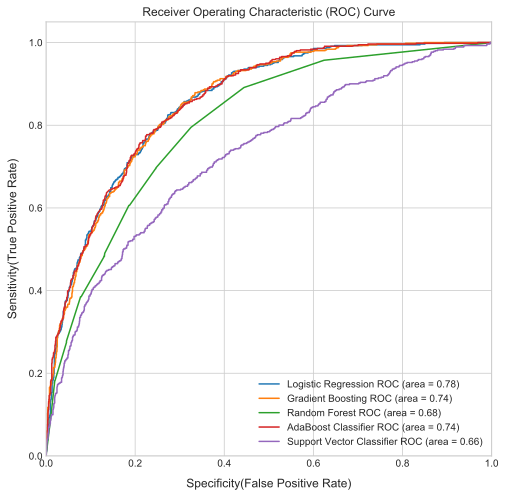

<Figure size 432x288 with 0 Axes>

In [118]:
plt.figure(figsize=(8, 8))

# Iterate through the list of models
for m in models:
    model = m['model']  # select the model
    model.fit(X_train_res, y_train_res)  # train the model
    y_pred = model.predict(X_test)  # predict the test data
    # Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    # Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test, model.predict(X_test))
    # Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
# plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Specificity(False Positive Rate)', fontsize=12, labelpad=10)
plt.ylabel('Sensitivity(True Positive Rate)', fontsize=12, labelpad=10)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=12)
plt.legend(loc="lower right")
plt.show()
plt.savefig('visualizations/ROC_curve.jpg', dpi=300)


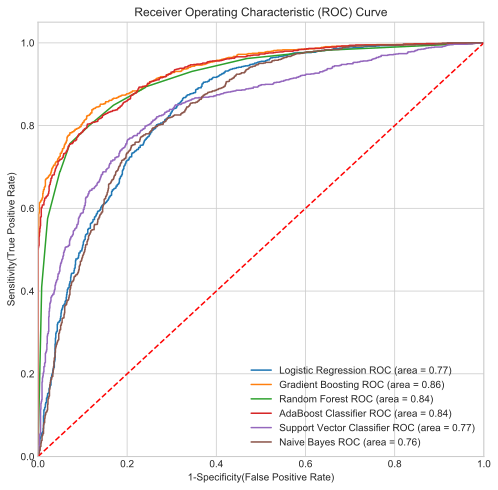

In [15]:
plt.figure(figsize=(8,8))

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': make_pipeline(StandardScaler(), LogisticRegression())
},
{
    'label': 'Gradient Boosting',
    'model': GradientBoostingClassifier(),
},
{
    'label': 'Random Forest',
    'model': RandomForestClassifier(),
},
{
    'label': 'AdaBoost Classifier',
    'model': AdaBoostClassifier(),
},
{
    'label': 'Support Vector Classifier',
    'model': SVC(probability=True),
},
{
    'label': 'Naive Bayes',
    'model': GaussianNB(),
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train_2, y_train_2) # train the model
    y_pred=model.predict(X_test_2) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test_2, model.predict_proba(X_test_2)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test_2,model.predict(X_test_2))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# plt.savefig('visualizations/ROC_curve.svg')

In [44]:
param_grid = {'C': [0.1, 10.]}

clf = make_pipeline(StandardScaler(), 
                    GridSearchCV(LogisticRegression(),
                                 param_grid=param_grid,
                                 cv=2,
                                 refit=True))

clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [45]:
y_test

5405    1
1247    1
5414    1
6666    0
4073    0
       ..
842     1
6797    0
6831    0
7012    0
3974    0
Name: churn, Length: 2321, dtype: int64

In [46]:
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [47]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1701
           1       0.62      0.55      0.58       620

   micro avg       0.79      0.79      0.79      2321
   macro avg       0.73      0.71      0.72      2321
weighted avg       0.78      0.79      0.79      2321



In [48]:
df['churn'].value_counts()

0    5163
1    1869
Name: churn, dtype: int64

In [49]:
1869/(5163+1869)

0.26578498293515357

In [50]:
clf = make_pipeline(StandardScaler(), 
                    GridSearchCV(LogisticRegression(),
                                 param_grid={'C': [0.1, 1.0, 10.]},
                                 cv=3,
                                 refit=True))

In [51]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gridsearchcv', GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_c...}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0))])

In [52]:
new_x = pd.DataFrame(X_train)

In [53]:
new_x.shape

(4711, 24)

In [54]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gridsearchcv', GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_c...}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0))])

In [55]:
new = clf.predict(new_x)

In [56]:
print(classification_report(y_test, new))

ValueError: Found input variables with inconsistent numbers of samples: [2321, 4711]

### Logistic Regression Tuning

In [59]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression())])
param_grid = [{'clf__C': [0.8, 1, 1.1, 1.2, 1.3, 1.5, 1.6], 'clf__class_weight': [None, 'balanced'],
               'clf__solver': ['liblinear', 'sag', 'saga']}]
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='recall')
gs.fit(X_train_res, y_train_res)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'clf__C': [0.8, 1, 1.1, 1.2, 1.3, 1.5, 1.6], 'clf__class_weight': [None, 'balanced'], 'clf__solver': ['liblinear', 'sag', 'saga']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [60]:
gs.best_params_

{'clf__C': 1.5, 'clf__class_weight': None, 'clf__solver': 'liblinear'}

In [61]:
pred = gs.predict(X_test)

In [62]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1549
           1       0.52      0.83      0.64       561

   micro avg       0.75      0.75      0.75      2110
   macro avg       0.72      0.78      0.72      2110
weighted avg       0.82      0.75      0.76      2110



In [257]:
print(confusion_matrix(y_test, pred))

[[1113  436]
 [  93  468]]


In [63]:
np.median(gs.cv_results_['mean_test_score'])

0.813503043718871

In [66]:
pred = gs.predict(X_train)

In [67]:
print(classification_report(y_train, pred))
print(confusion_matrix(y_train, pred))

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      3614
           1       0.52      0.81      0.63      1308

   micro avg       0.75      0.75      0.75      4922
   macro avg       0.72      0.77      0.72      4922
weighted avg       0.81      0.75      0.76      4922

[[2621  993]
 [ 246 1062]]


In [ ]:
pred.shape

In [68]:
logistic_gain_2 = []
i_vals = []
cost = []
savings = []
i = .01

pred = gs.predict(X_train)

for i in np.linspace(0, 1, 101):
    folds = KFold(n_splits=5, shuffle=True)
    probs = cross_val_predict(gs.best_estimator_, X_train, y_train, cv=folds, method='predict_proba', n_jobs=-1)
    probs = pd.DataFrame(probs)
    new_pred = probs[1].apply(lambda x: 1 if x > i else 0)
    conf = confusion_matrix(y_train, new_pred)

    total_cost = (conf[0][1] * 100) + (conf[1][1] * 100) + (conf[1][0] * 500)
    total_savings = conf[1][1] * 500

    net_gain = total_savings - total_cost
    logistic_gain_2.append(net_gain)
    i_vals.append(i)
    cost.append(total_cost)
    savings.append(total_savings)

print(f'Max net gain = {max(logistic_gain_2)}')


Max net gain = 270400


### Logistic Regression Tuning

In [178]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(random_state=11))])
param_grid = [{'clf__C': [0.001, 0.1, 1.0], 'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}]
gs = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='recall')
gs.fit(X_train_res, y_train_res)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=11, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'clf__C': [0.001, 0.1, 1.0], 'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [179]:
gs.best_params_

{'clf__C': 1.0, 'clf__solver': 'newton-cg'}

In [180]:
np.median(gs.cv_results_['mean_train_score'])

0.8084532385286909

In [181]:
pred = gs.predict(X_train)

In [182]:
print(classification_report(y_train, pred))
print(confusion_matrix(y_train, pred))

              precision    recall  f1-score   support

           0       0.91      0.72      0.81      3614
           1       0.52      0.81      0.63      1308

   micro avg       0.75      0.75      0.75      4922
   macro avg       0.71      0.77      0.72      4922
weighted avg       0.81      0.75      0.76      4922

[[2619  995]
 [ 247 1061]]


In [75]:
np.linspace(0, 1, 101)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

**This is our winning model**

In [65]:
logistic_gain = []
i_vals = []
cost = []
savings = []
i = .01

pred = gs.predict(X_train)

for i in np.linspace(0, 1, 101):
    folds = KFold(n_splits=5, shuffle=True)
    probs = cross_val_predict(gs.best_estimator_, X_train, y_train, cv=folds, method='predict_proba', n_jobs=-1)
    probs = pd.DataFrame(probs)
    new_pred = probs[1].apply(lambda x: 1 if x > i else 0)
    conf = confusion_matrix(y_train, new_pred)

    total_cost = (conf[0][1] * 100) + (conf[1][1] * 100) + (conf[1][0] * 500)
    total_savings = conf[1][1] * 500

    net_gain = total_savings - total_cost
    logistic_gain.append(net_gain)
    i_vals.append(i)
    cost.append(total_cost)
    savings.append(total_savings)

print(f'Max net gain = {max(logistic_gain)}')


Max net gain = 272200


In [67]:
for i, v in enumerate(logistic_gain):
    if v == 272200:
        print(i)

11


In [56]:
probs = pd.DataFrame(gs.predict_proba(X_train))
new_pred = probs[1].apply(lambda x: 1 if x > 0.22 else 0)
conf = confusion_matrix(y_train, new_pred)
print(conf)

[[1718 1896]
 [  69 1239]]


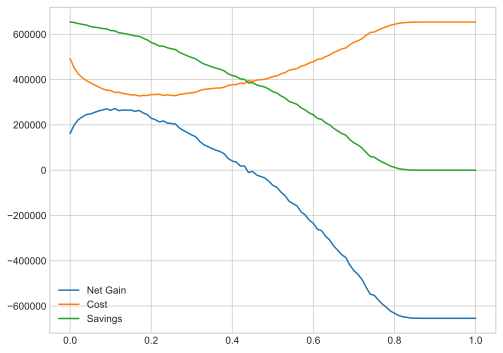

In [68]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(i_vals, logistic_gain, label='Net Gain')
plt.plot(i_vals, cost, label='Cost')
plt.plot(i_vals,savings, label='Savings')
plt.legend(loc=0)

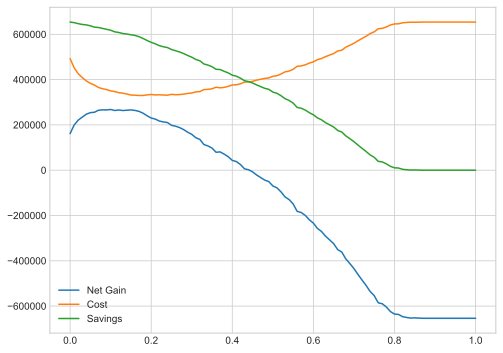

In [97]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(i_vals, logistic_gain, label='Net Gain')
plt.plot(i_vals, cost, label='Cost')
plt.plot(i_vals,savings, label='Savings')
plt.legend(loc=0)

**Calculating our total cost and total savings to get net gain:**

In [28]:
conf = confusion_matrix(y_train, pred)

In [33]:
total_cost = (conf[0][1] * 100) + (conf[1][1] * 100)
total_savings = conf[1][1] * 500

In [37]:
net_gain = total_savings - total_cost
print(net_gain)

324900


In [82]:
gs.score(X_train, y_train)

0.6796636085626911

In [39]:
coeffs = gs.best_estimator_.named_steps['clf'].coef_[0]
list_of_coeffs = list(sorted(zip(coeffs * 10, X.columns)))


### Gradient Boosting Tuning

In [76]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', GradientBoostingClassifier())])
param_grid = [{'clf__learning_rate': [0.01, 0.1, 0.5, 1], 'clf__loss': ['deviance', 'exponential'],
               'clf__n_estimators': [50, 100, 150], 'clf__max_depth': [2, 3, 4]}]
gs = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='recall')
gs.fit(X_train_res, y_train_res)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decreas...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'clf__learning_rate': [0.01, 0.1, 0.5, 1], 'clf__loss': ['deviance', 'exponential'], 'clf__n_estimators': [50, 100, 150], 'clf__max_depth': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [77]:
gs.best_params_

{'clf__learning_rate': 0.1,
 'clf__loss': 'exponential',
 'clf__max_depth': 2,
 'clf__n_estimators': 50}

In [78]:
gs.best_score_

0.8367459878251245

In [79]:
np.median(gs.cv_results_['mean_test_score'])

0.7963475373547316

In [81]:
pred2 = gs.predict(X_train)
print(classification_report(y_train, pred2))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      3614
           1       0.58      0.68      0.63      1308

   micro avg       0.79      0.79      0.79      4922
   macro avg       0.73      0.75      0.74      4922
weighted avg       0.80      0.79      0.79      4922



In [33]:
pred2 = gs.predict(X_train)
print(classification_report

Max net gain = 265200


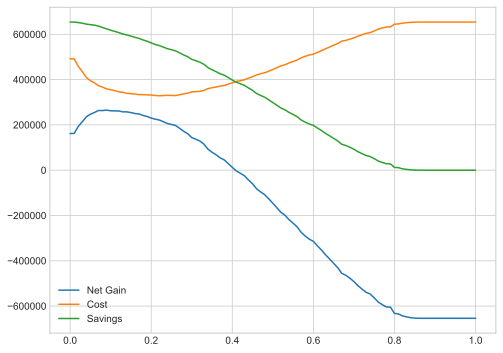

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(i_vals, gradboost_gain, label='Net Gain')
plt.plot(i_vals, cost, label='Cost')
plt.plot(i_vals, savings, label='Savings')
plt.legend(loc=0)
# plt.savefig('gradientboost_triple.svg')


### AdaBoost Tuning

In [83]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', AdaBoostClassifier())])
param_grid = [{'clf__learning_rate': [0.01, 0.1, 1], 'clf__algorithm': ['SAMME'], 'clf__n_estimators': [25, 50, 100]}]
gs = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='recall')
gs.fit(X_train_res, y_train_res)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'clf__learning_rate': [0.01, 0.1, 1], 'clf__algorithm': ['SAMME'], 'clf__n_estimators': [25, 50, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [84]:
gs.best_params_

{'clf__algorithm': 'SAMME', 'clf__learning_rate': 0.1, 'clf__n_estimators': 25}

In [85]:
np.median(gs.cv_results_['mean_test_score'])

0.8060320973990038

In [86]:
pred = gs.predict(X_train)
print(classification_report(y_train, pred))

              precision    recall  f1-score   support

           0       0.90      0.69      0.78      3614
           1       0.47      0.78      0.59      1308

   micro avg       0.71      0.71      0.71      4922
   macro avg       0.69      0.73      0.68      4922
weighted avg       0.78      0.71      0.73      4922



In [48]:
np.median(gs.cv_results_['mean_test_score'])

0.8004980630879911

In [49]:
pred = gs.predict(X_train)
print(classification_report(y_train, pred))

              precision    recall  f1-score   support

           0       0.89      0.77      0.83      3614
           1       0.54      0.74      0.62      1308

   micro avg       0.76      0.76      0.76      4922
   macro avg       0.71      0.75      0.72      4922
weighted avg       0.80      0.76      0.77      4922



In [50]:
np.median(gs.cv_results_['mean_test_score'])

0.8004980630879911

In [87]:
adaboost_gain = []
i_vals = []
cost = []
savings = []

pred = gs.predict(X_train)

for i in np.linspace(0.0, 1.0, 101):
    folds = KFold(n_splits=5, shuffle=True)
    probs = cross_val_predict(gs.best_estimator_, X=X_train, y=y_train, cv=folds, method='predict_proba', n_jobs=-1)
    probs = pd.DataFrame(probs)
    #     probs = pd.DataFrame(gs.predict_proba(X_train))
    new_pred = probs[1].apply(lambda x: 1 if x > i else 0)
    conf = confusion_matrix(y_train, new_pred)

    total_cost = (conf[0][1] * 100) + (conf[1][1] * 100) + conf[1][0] * 500
    total_savings = conf[1][1] * 500

    net_gain = total_savings - total_cost
    adaboost_gain.append(net_gain)
    i_vals.append(i)
    cost.append(total_cost)
    savings.append(total_savings)

print(f'Max net gain = {max(adaboost_gain)}')


Max net gain = 246200


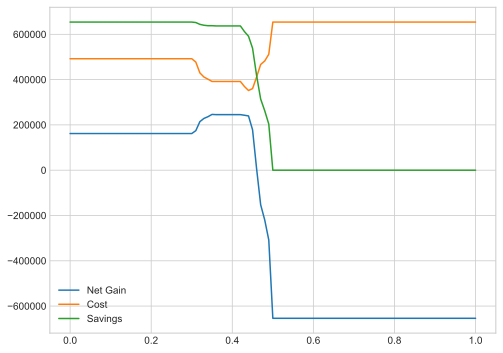

In [88]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(i_vals, adaboost_gain, label='Net Gain')
plt.plot(i_vals, cost, label='Cost')
plt.plot(i_vals,savings, label='Savings')
plt.legend(loc=0)

### Random Forest Tuning

In [53]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier())])
param_grid = [{'clf__max_depth': [4, 5, 6], 'clf__max_features': [5, 10, 15, 20], 'clf__n_estimators': [50, 100, 150]}]
gs = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='recall')
gs.fit(X_train_res, y_train_res)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
     ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'clf__max_depth': [4, 5, 6], 'clf__max_features': [5, 10, 15, 20], 'clf__n_estimators': [50, 100, 150]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [54]:
gs.best_params_

{'clf__max_depth': 6, 'clf__max_features': 5, 'clf__n_estimators': 100}

In [55]:
np.median(gs.cv_results_['mean_test_score'])

0.8190370780298838

In [56]:
pred = gs.predict(X_train)
print(classification_report(y_train, pred))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      3614
           1       0.60      0.72      0.66      1308

   micro avg       0.80      0.80      0.80      4922
   macro avg       0.75      0.77      0.76      4922
weighted avg       0.81      0.80      0.80      4922



In [57]:
# Test against our test set
gs.score(X_test, y_test)

0.7379679144385026

In [58]:
randforest_gain = []
i_vals = []
cost = []
savings = []

pred = gs.predict(X_train)

for i in np.linspace(0.0, 1.0, 101):
    folds = KFold(n_splits=5, shuffle=True)
    probs = cross_val_predict(gs.best_estimator_, X_train, y_train, cv=folds, method='predict_proba', n_jobs=-1)
    probs = pd.DataFrame(probs)
    #     probs = pd.DataFrame(gs.predict_proba(X_train))
    new_pred = probs[1].apply(lambda x: 1 if x > i else 0)
    conf = confusion_matrix(y_train, new_pred)

    total_cost = (conf[0][1] * 100) + (conf[1][1] * 100) + conf[1][0] * 500
    total_savings = conf[1][1] * 500

    net_gain = total_savings - total_cost
    randforest_gain.append(net_gain)
    i_vals.append(i)
    cost.append(total_cost)
    savings.append(total_savings)

print(f'Max net gain = {max(randforest_gain)}')


Max net gain = 262800


#### Pickle lists so we don't have to run everything again

In [127]:
def make_backups():
    with open('backups/randforest.pkl', 'wb') as f:
        pickle.dump(randforest_gain, f)
        
    with open('backups/logistic.pkl', 'wb') as f:
        pickle.dump(logistic_gain, f)
        
    with open('backups/gradboost.pkl', 'wb') as f:
        pickle.dump(gradboost_gain, f)
        
# make_backups()

#### Compute base cases where we predict all customers will churn, and none will churn

In [128]:
y_train.shape

(4922,)

In [203]:
new_pred_ones = np.ones(shape=(4922,))

conf = confusion_matrix(y_train, new_pred_ones)

total_cost = (conf[0][1] * 100) + (conf[1][1] * 100) + conf[1][0] * 500
total_savings = conf[1][1] * 500

net_gain = total_savings - total_cost
print(net_gain)


161800


In [204]:
new_pred_zeros = np.zeros(shape=(4922,))

conf = confusion_matrix(y_train, new_pred_zeros)

total_cost = (conf[0][1] * 100) + (conf[1][1] * 100) + conf[1][0] * 500
total_savings = conf[1][1] * 500

net_gain = total_savings - total_cost
print(net_gain)


-654000


In [131]:
conf

array([[   0, 3614],
       [   0, 1308]])

In [132]:
net_gain

161800

#### Compute base case where we do nothing

In [137]:
# 1308 customers will churn, at an average cost to replace of $500 each
# $654,000 loss, which is why our predictions bottom out at that number on the following chart (good to confirm that it does!)
1308 * 500

654000

### Plot all Net Gain scores against each other

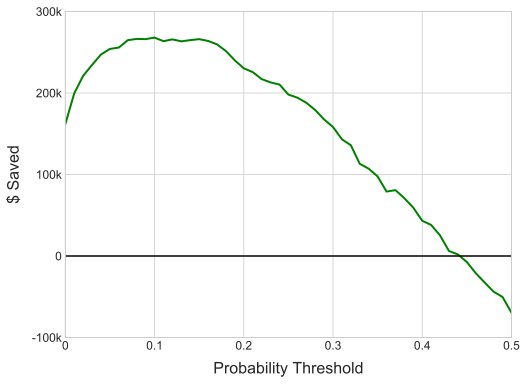

In [107]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(i_vals, logistic_gain, label='Logistic Regression', color='green', lw=2)
ax.axhline(y=0, color='black')
ax.set_xlabel('Probability Threshold', fontsize=16, labelpad=10)
ax.set_ylabel('$ Saved', rotation=90, fontsize=16, labelpad=10)
ax.set_yticklabels(['-100k', '0', '100k', '200k', '300k'], fontsize=12)
ax.set_xticklabels(['0', '0.1', '0.2', '0.3', '0.4', '0.5'], fontsize=12)
ax.set_yticks([-100000, 0, 100000, 200000, 300000])
ax.set_xbound(lower=0, upper=0.5)
ax.set_ybound(lower=-100000, upper=300000)
# plt.savefig('visualizations/net_cost_8.jpg', dpi=300)


In [1]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(i_vals, logistic_gain, label='Logistic Regression', lw=2)
plt.plot(i_vals, randforest_gain, label='Random Forests', lw=2)
plt.plot(i_vals, gradboost_gain, label='Gradient Boost', lw=2)
plt.legend(loc=0)
ax.set_xlabel('Probability Threshold', fontsize=16, labelpad=10)
ax.set_ylabel('$ Saved', rotation=90, fontsize=16, labelpad=10)
ax.set_xbound(lower=0, upper=1)
# plt.savefig('visualizations/net_cost_9.jpg', dpi=300)


NameError: name 'plt' is not defined

##  Cost minimization: 

In [42]:
def makecost(obs,prob,falsepos_cost,falseneg_cost):
    def cost(cutoff):
        pred = np.array(prob > cutoff)
        fpos = pred * (1 - obs)
        fneg = (1 - pred) * obs
        return np.sum(fpos * falsepos_cost + fneg * falseneg_cost)
    return np.vectorize(cost)

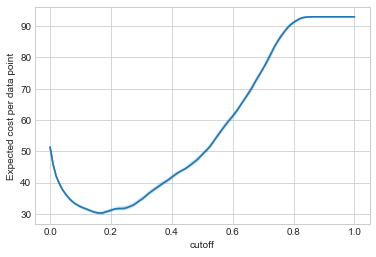

In [45]:
cut = np.linspace(0, 1, 100)
cost = np.zeros_like(cut)
from sklearn.model_selection import KFold, cross_val_predict

obs = y_train

K = 20
for j in range(K):
    folds = KFold(n_splits=5, shuffle=True)
    prob = cross_val_predict(gs.best_estimator_, X_train, obs, cv=folds, method='predict_proba', n_jobs=5)[:, 1]
    getcost = makecost(obs, prob, falsepos_cost=100, falseneg_cost=500)
    currentcost = getcost(cut) / X.shape[0]
    cost += currentcost
    plt.plot(cut, currentcost, c='C0', alpha=0.05)
cost /= K
plt.plot(cut, cost, c='C0')
plt.xlabel('cutoff')
plt.ylabel('Expected cost per data point');


In [44]:
bestcut = cut[np.argmin(cost)]
bestcut

0.16161616161616163

In [119]:
categories = ['Logistic Regression', 'AdaBoost', 'Random Forests', 'Gradient Boosting']
recall_pct = [0.81, 0.74, 0.72, 0.68]
net_gain = [272000, 257200, 262800, 263600]

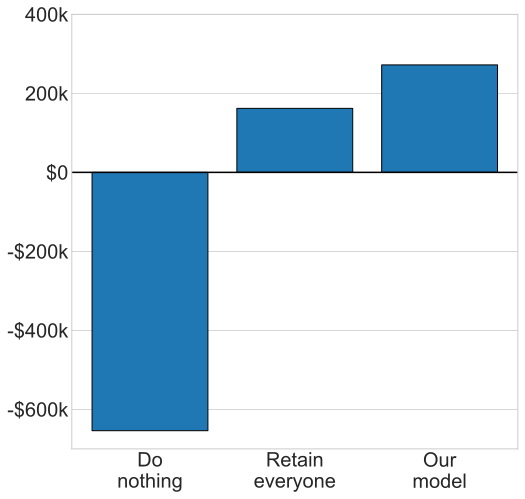

In [174]:
categories = ['Do nothing', 'Assume everyone will churn', 'Our model']
gain = [-654000, 162000, 272000]

fig, ax = plt.subplots(figsize=(8,8))
barlist = ax.bar(categories, gain, edgecolor='black')
ax.axhline(y=0, color='black')
ax.set_xticklabels(['Do\nnothing', 'Retain\neveryone', 'Our\nmodel'], fontsize=20)
ax.set_yticklabels(['-$600k', '-$400k', '-$200k', '$0', '200k','400k'], fontsize=20)
ax.set_yticks([-600000, -400000, -200000, 0, 200000, 400000])
ax.set_ybound(lower=-700000, upper=400000)
barlist[2].set_edgecolor('black')
plt.grid(axis='x')
# plt.savefig('visualizations/our_model.jpg', dpi=300)

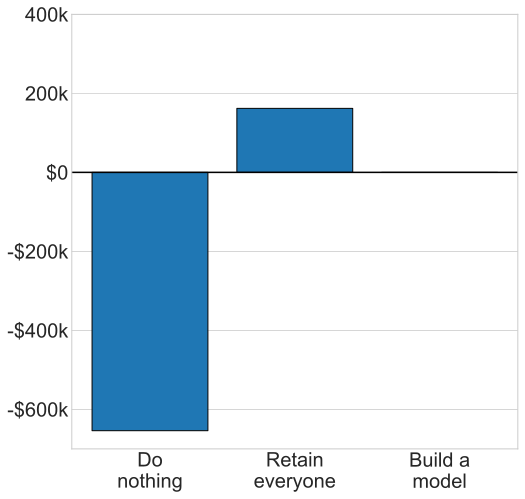

In [177]:
categories = ['Do nothing', 'Assume everyone will churn', 'Build a model']
gain = [-654000, 162000, 0]

fig, ax = plt.subplots(figsize=(8,8))
barlist = ax.bar(categories, gain, edgecolor='black')
ax.axhline(y=0, color='black')
ax.set_xticklabels(['Do\nnothing', 'Retain\neveryone', 'Build a\nmodel'], fontsize=20)
ax.set_yticklabels(['-$600k', '-$400k', '-$200k', '$0', '200k','400k'], fontsize=20)
ax.set_yticks([-600000, -400000, -200000, 0, 200000, 400000])
ax.set_ybound(lower=-700000, upper=400000)
plt.grid(axis='x')
# plt.savefig('visualizations/model_comparison.jpg', dpi=300)